# 2022 NZMSA Data Science Submission.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import RidgeCV

%matplotlib inline

# Exploratory Data Analysis.

In [2]:
dataset = pd.read_csv("weather-data.csv")
dataset.head() # Show the first five results.

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0    station        103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


In [4]:
# convert valid column to datetime format
dataset['valid'] = pd.to_datetime(dataset['valid'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0    station        103713 non-null  object        
 1   valid           103713 non-null  datetime64[ns]
 2   tmpc            103678 non-null  float64       
 3   dwpc            103678 non-null  float64       
 4   relh            103593 non-null  float64       
 5   sknt            103704 non-null  float64       
 6   gust            1203 non-null    float64       
 7   peak_wind_drct  0 non-null       float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.3+ MB


In [5]:
# Description.
# Mean - Average value of the data.
# std (Standard Deviation) - How far away from the mean is the overall data?
# 25% - The 25th percentile value.
# 75% - The 75th percentile value.
dataset.describe()

,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000,0.0
mean,15.811503,12.115772,79.782307,8.919029,30.962594,NaN
std,4.235197,3.738005,12.562199,5.348379,6.319510,NaN
min,2.000000,-2.000000,29.230000,0.000000,13.000000,NaN
25%,13.000000,9.000000,71.450000,5.000000,27.000000,NaN
50%,16.000000,12.000000,81.990000,8.000000,31.000000,NaN
75%,19.000000,15.000000,88.180000,12.000000,35.000000,NaN
max,29.000000,23.000000,100.000000,42.000000,56.000000,NaN


<AxesSubplot:>

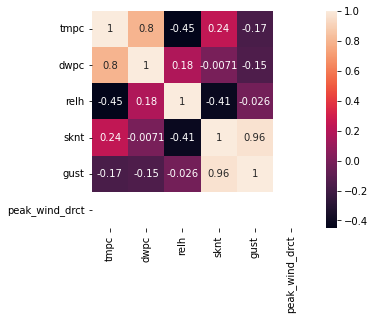

In [6]:
# Correlation plot.
# Values nearing one or negative one can have a pattern where a(x) = k*b(x)
# Values closer to the 0 value indicates the plot of a(x) and b(x) has no noticeable pattern.

sns.heatmap(dataset.corr(), annot=True, square=True)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\1828561053.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


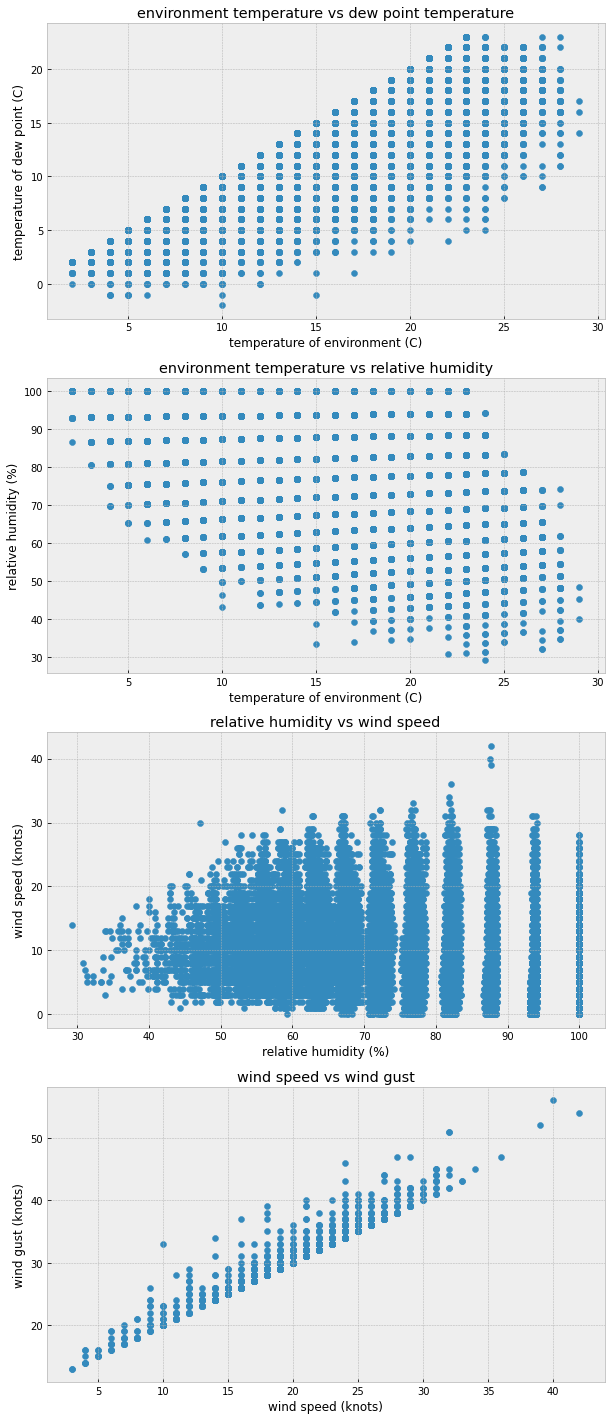

In [7]:
# plots of numerical sections of data set
plt.style.use("bmh")
fig, axs = plt.subplots(nrows=4, ncols=1, squeeze=True)

features = {
    "tmpc": {"title": "environment temperature", "label": "temperature of environment (C)"},
    "dwpc": {"title": "dew point temperature", "label": "temperature of dew point (C)"},
    "relh": {"title": "relative humidity", "label": "relative humidity (%)"},
    "sknt": {"title": "wind speed", "label": "wind speed (knots)"},
    "gust": {"title": "wind gust", "label": "wind gust (knots)"},
}

comparisons = [
    ("tmpc", "dwpc"),
    ("tmpc", "relh"),
    ("relh", "sknt"),
    ("sknt", "gust")
]

for i, pair in enumerate(comparisons):
    x_name, y_name = pair
    x = features[x_name]
    y = features[y_name]
    axs[i].scatter(dataset[x_name], dataset[y_name])
    axs[i].set_title(f"{x['title']} vs {y['title']}")
    axs[i].set_xlabel(x['label'])
    axs[i].set_ylabel(y['label'])
    
fig.set_size_inches(10,25)

fig.show()

In [8]:
# Time series plotter function
def plot_time_series(dataset, x_name, y_names, y_dict, window=1, last_hours=0):
    plt.style.use("bmh")
    fig, axs = plt.subplots(nrows=len(y_names), ncols=1, squeeze=True)

    last_hours = slice(-last_hours*2, None)

    for i, y_name in enumerate(y_names):
        y = y_dict[y_name]
        y_average = dataset[y_name].rolling(window).mean()
        axs[i].plot(dataset[x_name].values[last_hours], y_average.values[last_hours])
        axs[i].set_title(f"Time series of {y['title']}")
        axs[i].set_xlabel("Date")
        axs[i].set_ylabel(y['label'])
    
    fig.set_size_inches(10,25)
    fig.show()

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\2126668918.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


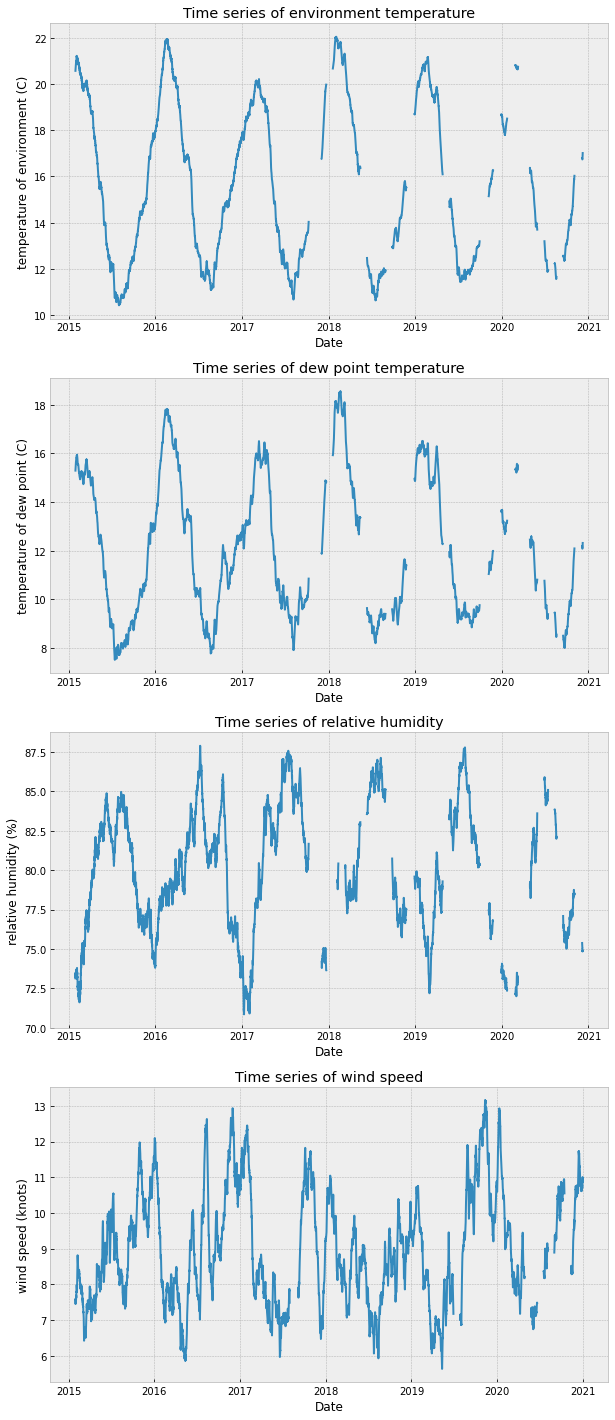

In [9]:
target_names = ["tmpc", "dwpc", "relh", "sknt"]

# Time series plots (long term)
plot_time_series(dataset, "valid", target_names, features, window=1344)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\2126668918.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


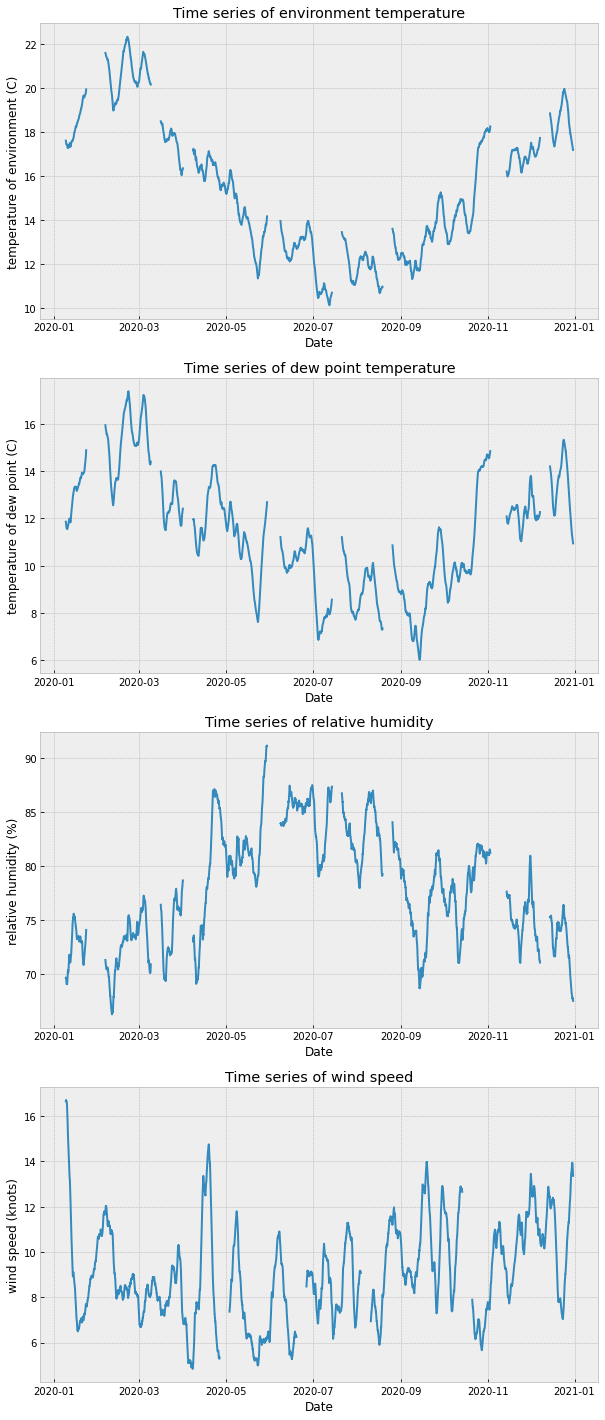

In [10]:
# Time series plots (1 year)
plot_time_series(dataset, "valid", target_names, features, window=336, last_hours=8544)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\2126668918.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


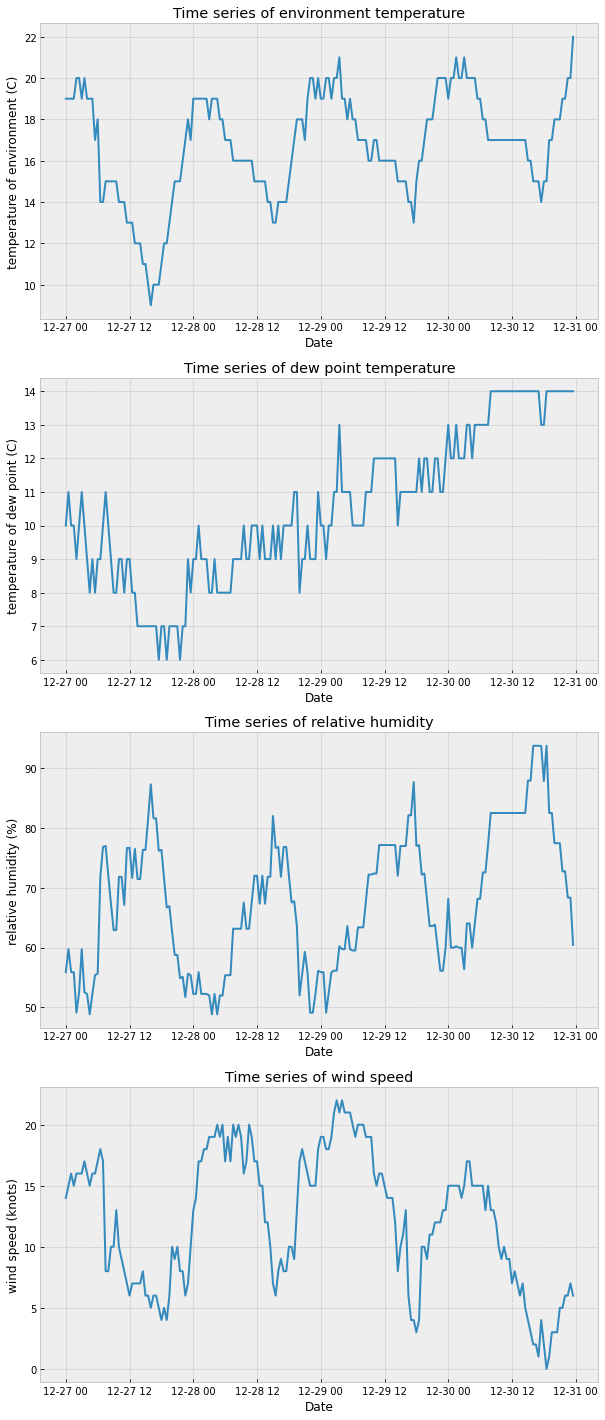

In [11]:
# Time series plots (3 days)
plot_time_series(dataset, "valid", target_names, features, last_hours=96)

Comments:

The average dew point temperature of 12.1C is lower than the average environment temperature of 15.8C.

The average wind gust of 31.0 knots is higher than the average wind speed of 8.9 knots, which makes sense as wind gusts are stronger bursts that aren't sustained.

Unsurprisingly, there is a positive relationship between the temperature of the environment and the dew point temperature in the environment. There is also a strong positive relationship between the wind speed and the wind gust.

There appears to be a negative relationship between relative humidity of the environment and temperature of the environment.

There appears to be a seasonal trend in the data, with the environment temperature, dew point temperature and wind speed and peaking at around February and dipping at around July, and vice versa for relative humidity.

There are also daily trends in the data, with the environment temperature and wind speed peaking at around 4am and dipping at around 6pm. The relative humidity follows the opposite trend, peaking at around 6pm and dipping at around 4am. However, the dew point temperature, whilst roughly following the same trend as environment temperature, is a lot less regular. The daily trend in wind speed is also relatively irregular.

There appears to be no long term trends in the data over the years.

# Data Processing

In [12]:
# An exhaustive list of what you can do with Pandas dataframe is in this link: https://pandas.pydata.org/docs/reference/frame.html

In [13]:
# Drop non-numerical columns
dataset.drop(columns=[" station","peak_wind_drct"], inplace=True)

# Drop gust (too few data points)
dataset.drop(columns=["gust"], inplace=True)

# Drop rows with NaN
dataset.dropna(inplace=True)

In [14]:
# Separate date into month and hour components (ignore year since no long term trend observed)
dataset["month"] = dataset["valid"].dt.month
dataset["hour"] = dataset["valid"].dt.hour

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103584 entries, 0 to 103712
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   valid   103584 non-null  datetime64[ns]
 1   tmpc    103584 non-null  float64       
 2   dwpc    103584 non-null  float64       
 3   relh    103584 non-null  float64       
 4   sknt    103584 non-null  float64       
 5   month   103584 non-null  int64         
 6   hour    103584 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 6.3 MB


In [16]:
def assign_test_train(X, y, train, test):
    return (X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test])


In [17]:
target_names = ["tmpc","dwpc","relh","sknt"]
input_names = ["month","hour"]

# Separating inputs and outputs
X = dataset[input_names]
y = dataset[target_names]

# Splitting into training and testing data sets
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=96,
    max_train_size=50000,
    test_size=10000
)

all_splits = list(ts_cv.split(X, y))

trainX, trainY, testX, testY = assign_test_train(X, y, *all_splits[0])

In [18]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 3488 to 53579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   month   50000 non-null  int64
 1   hour    50000 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [19]:
trainY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 3488 to 53579
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmpc    50000 non-null  float64
 1   dwpc    50000 non-null  float64
 2   relh    50000 non-null  float64
 3   sknt    50000 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


In [20]:
testX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 53676 to 63678
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   month   10000 non-null  int64
 1   hour    10000 non-null  int64
dtypes: int64(2)
memory usage: 234.4 KB


In [21]:
testY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 53676 to 63678
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmpc    10000 non-null  float64
 1   dwpc    10000 non-null  float64
 2   relh    10000 non-null  float64
 3   sknt    10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


# Data Modelling

In [22]:
# An exhaustive list of models can be found in sci-kit learn in this link: https://scikit-learn.org/stable/supervised_learning.html
# The url takes you to supervised learning which is what you will be dealing with for this phase.

In [23]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True
    )

month_hour_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"])
    ],
    remainder=MinMaxScaler(),
)

periodic_spline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions", month_hour_interaction),
        ]
    ),
    RidgeCV(alphas=np.logspace(-6,6,25)),
)

In [24]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, -6, 25)

month_hour_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("month", one_hot_encoder, ["month"]),
            ("hour", one_hot_encoder, ["hour"])
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

one_hot_transformer = ColumnTransformer(
    transformers=[
        ("one_hot_time", one_hot_encoder, ["month", "hour"]),
    ],
    remainder=MinMaxScaler,
)

one_hot = make_pipeline(
    FeatureUnion(
        [
            ("marginal", one_hot_transformer),
            ("interactions", month_hour_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)

In [25]:
def make_predictions(model, testX, testY, names, window=1, last_hours=0):
    # Predict values against test set
    predictions = pd.DataFrame()
    predictions[names] = model.predict(testX)

    last_hours = slice(-last_hours*2, None)

    fig, axs = plt.subplots(nrows=4)

    # Plot predictions against actual data
    for i, name in enumerate(names):
        y_average = testY[name].rolling(window).mean()
        predictions_average = predictions[name].rolling(window).mean()
        axs[i].set_title(name)
        axs[i].plot(y_average.values[last_hours],label="Actual data")
        axs[i].plot(predictions_average.values[last_hours],label="Prediction")
        axs[i].legend()

    fig.set_size_inches(10,25)

    fig.show()

In [26]:
# Fit one hot encoder model to training set
model1 = one_hot.fit(trainX, trainY)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\1371463907.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


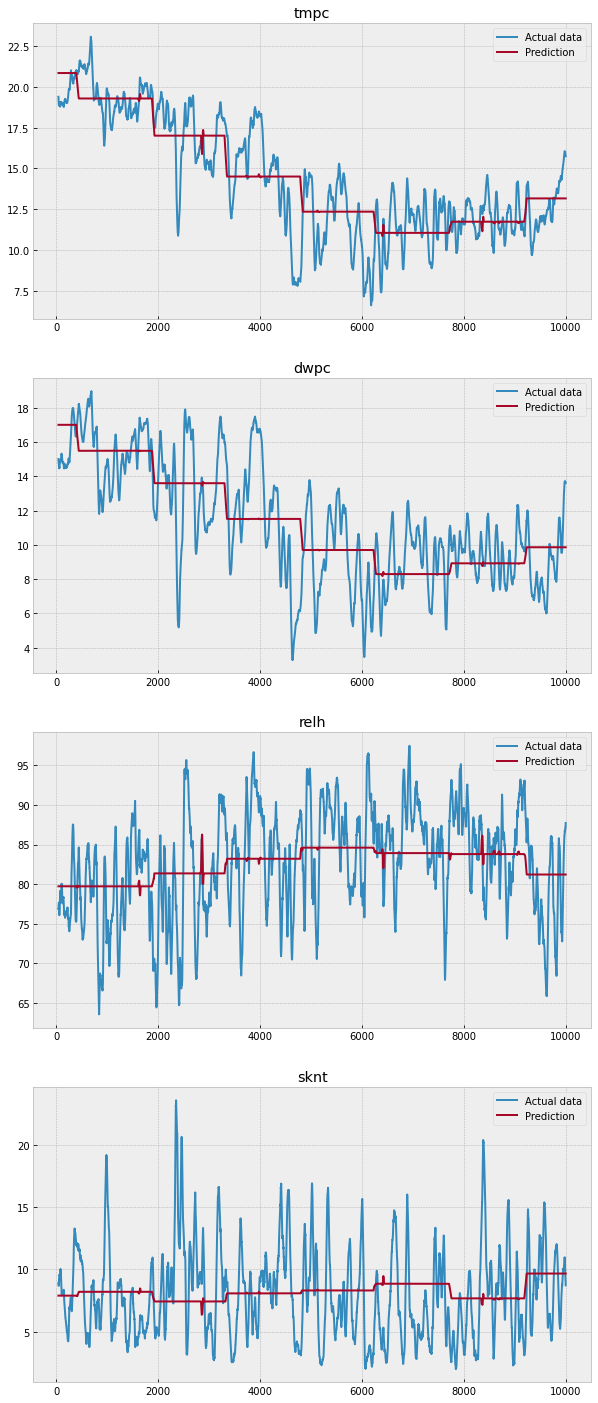

In [27]:
# Prediction of whole test set with rolling average in 2 day windows
make_predictions(model1, testX, testY, window=48, names=target_names)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\1371463907.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


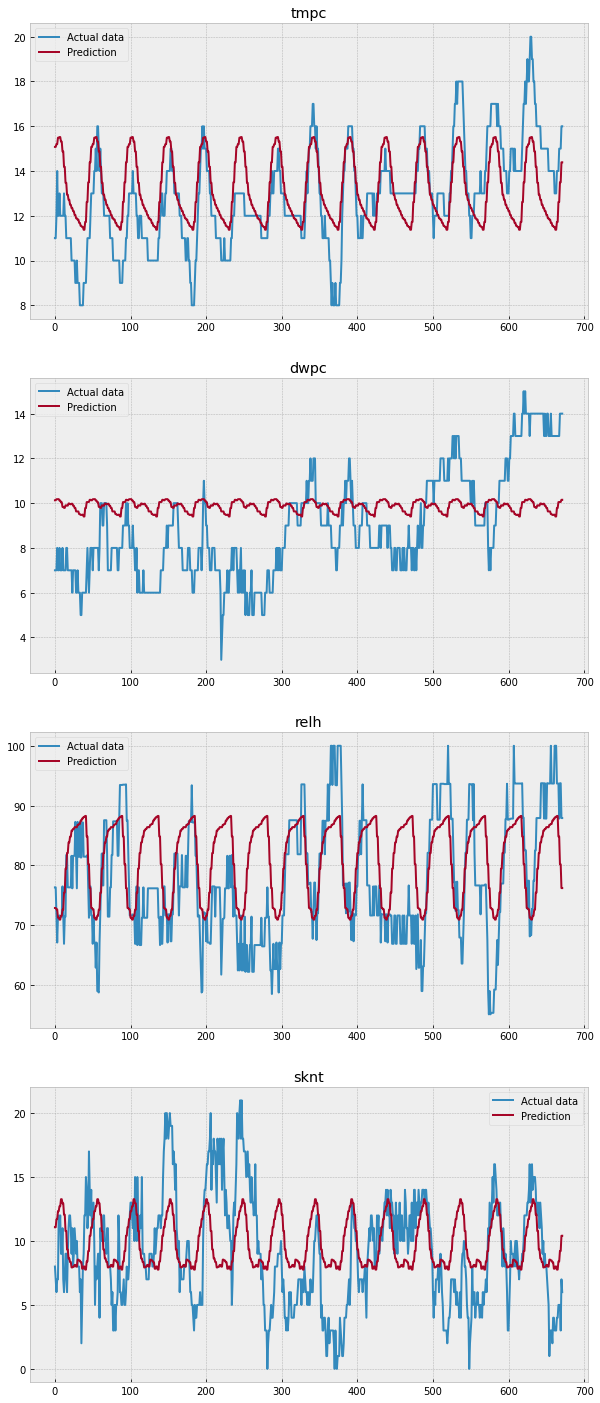

In [28]:
# Prediction of last 14 days in test set
make_predictions(model1, testX, testY, names=target_names, last_hours=336)

In [29]:
model1.score(testX, testY)

0.40162534712809994

In [30]:
# Fit periodic spline model to training set
model2 = periodic_spline.fit(trainX, trainY)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\1371463907.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


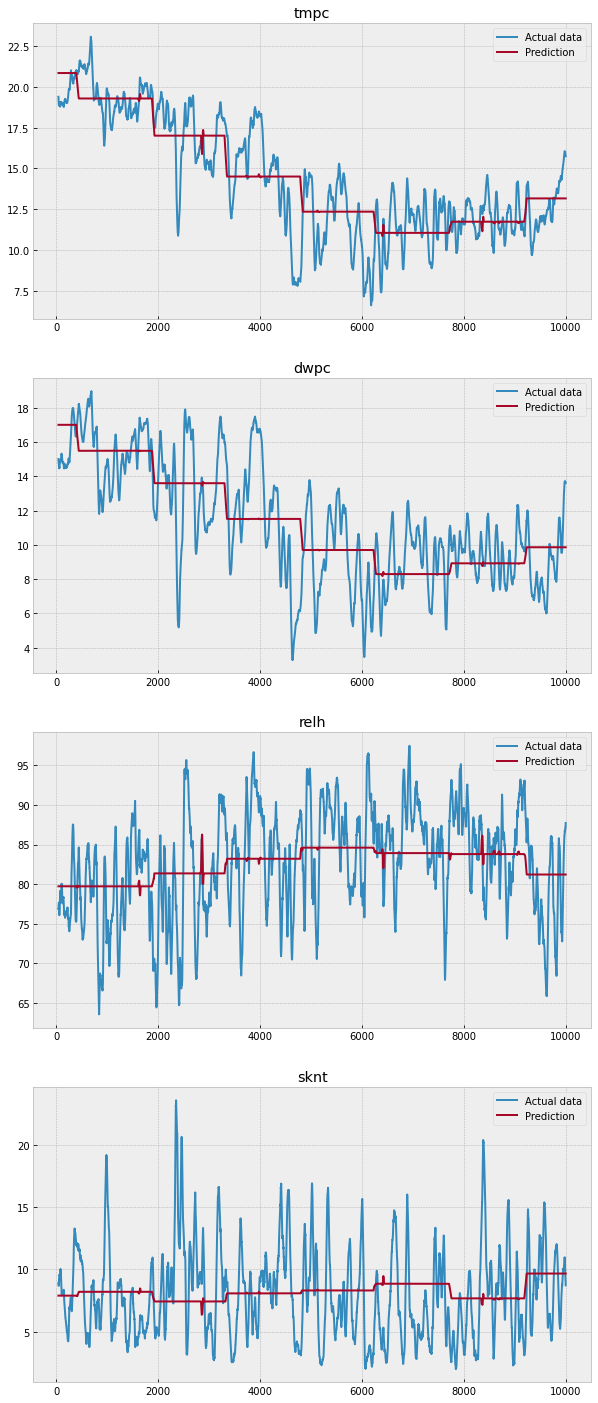

In [31]:
# Prediction of whole test set with rolling average in 2 day windows
make_predictions(model1, testX, testY, window=48, names=target_names)

C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\1371463907.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


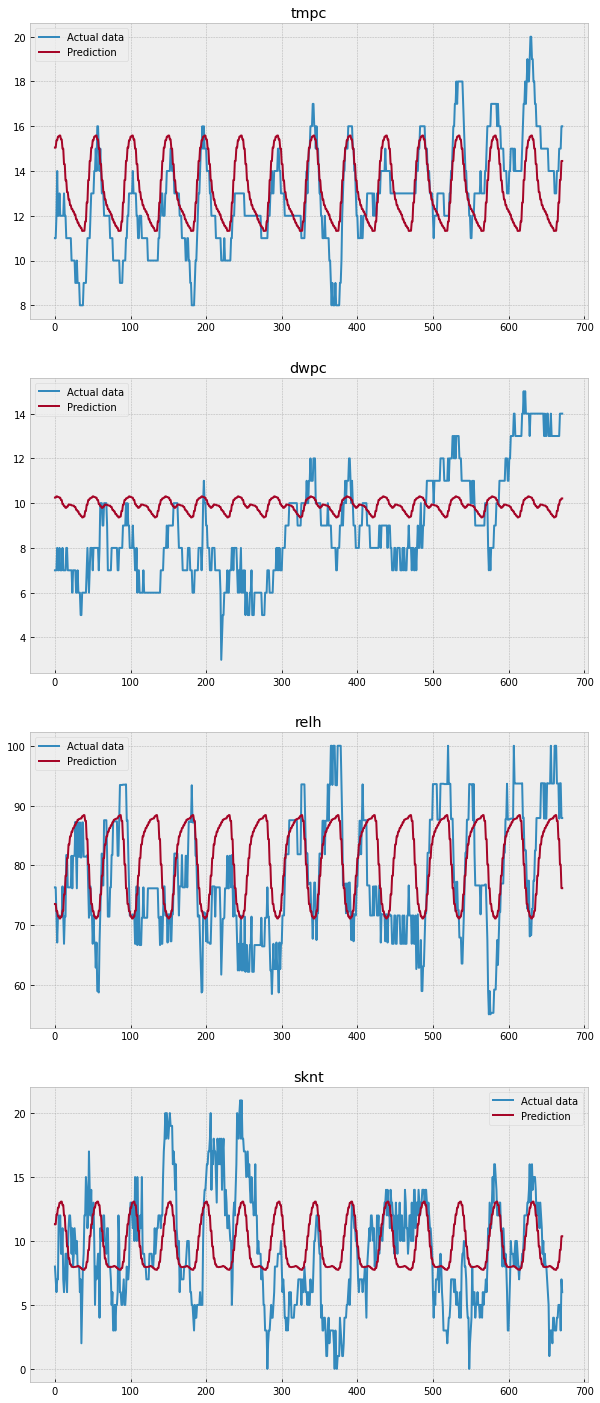

In [32]:
# Prediction of last 14 days in test set
make_predictions(model2, testX, testY, names=target_names, last_hours=336)

In [33]:
model2.score(testX, testY)

0.4036237170013477

In [34]:
# Create dataframe for forecast
forecast = pd.DataFrame()

# Generate datetimes ranging from 1 Jan 2021 to 31 Jan 2021, hourly frequency
forecast["date"] = pd.date_range(start="2021-01-01", end="2021-01-31", freq="H")

# Separate date into components
forecast["month"] = forecast["date"].dt.month
forecast["hour"] = forecast["date"].dt.hour

# Perform forecast
forecast[target_names] = model2.predict(forecast[input_names])


C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_25616\104525620.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


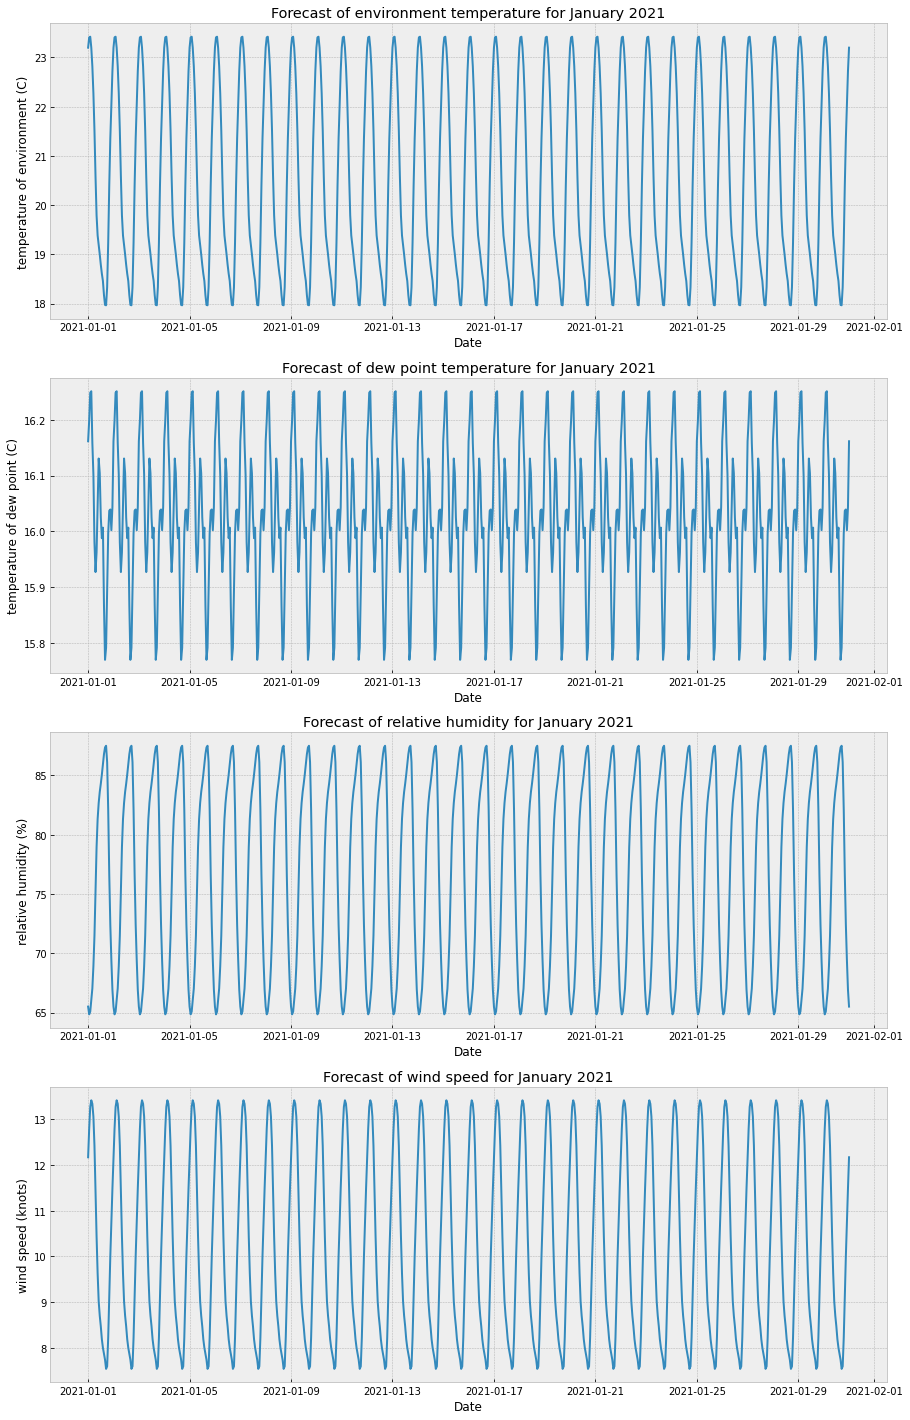

In [35]:
# Plot forecasts
fig, axs = plt.subplots(nrows=4)

for i, name in enumerate(target_names):
    target = features[name]
    axs[i].plot(forecast["date"], forecast[name])
    axs[i].set_title(f"Forecast of {target['title']} for January 2021")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel(target['label'])

fig.set_size_inches(15,25)

fig.show()


# Conclusion

* Comment on your model performance.
* Anything interesting about the data analysis.

I fitted a one hot encoder model and a periodic spline model to the training data. I used the periodic spline model for forecasting as it had a higher score.

The model performed decently in predicting environment temperature and relative humidity due to their regular pattern. However, it performed particularly poorly in predicting dew point temperature as the actual data has a lot of random fluctuation. It also performed fairly poorly in predicting wind speed.

The model fails to predict the sharp spikes in the actual data. This is especially probablematic in predicting dew point temperature, and to some extent wind speed, as the random fluctuation in the training data has lead to lower cycle amplitudes in the model.

Another problem with the model is the discontinuity between months as the months are treated as discrete rather than continuous. I considered decreasing the subdivision of the year to weeks, but that resulted in overfitting of the model.

It would be useful if the model accounted for uncertainty with confidence intervals for predictions, especially as some predictions are more uncertain than others. Confidence intervals are also useful for forecasting since predictions grow more uncertain further into the future.

It would also be useful if the model weighted recent data more heavily when making forecasts.

In conclusion, while the model does explain the seasonal trends in the data, it is not reliable for predicting and forecasting into the future, especially dew point temperature and wind speed.